# Préparez des données pour un organisme de santé publique

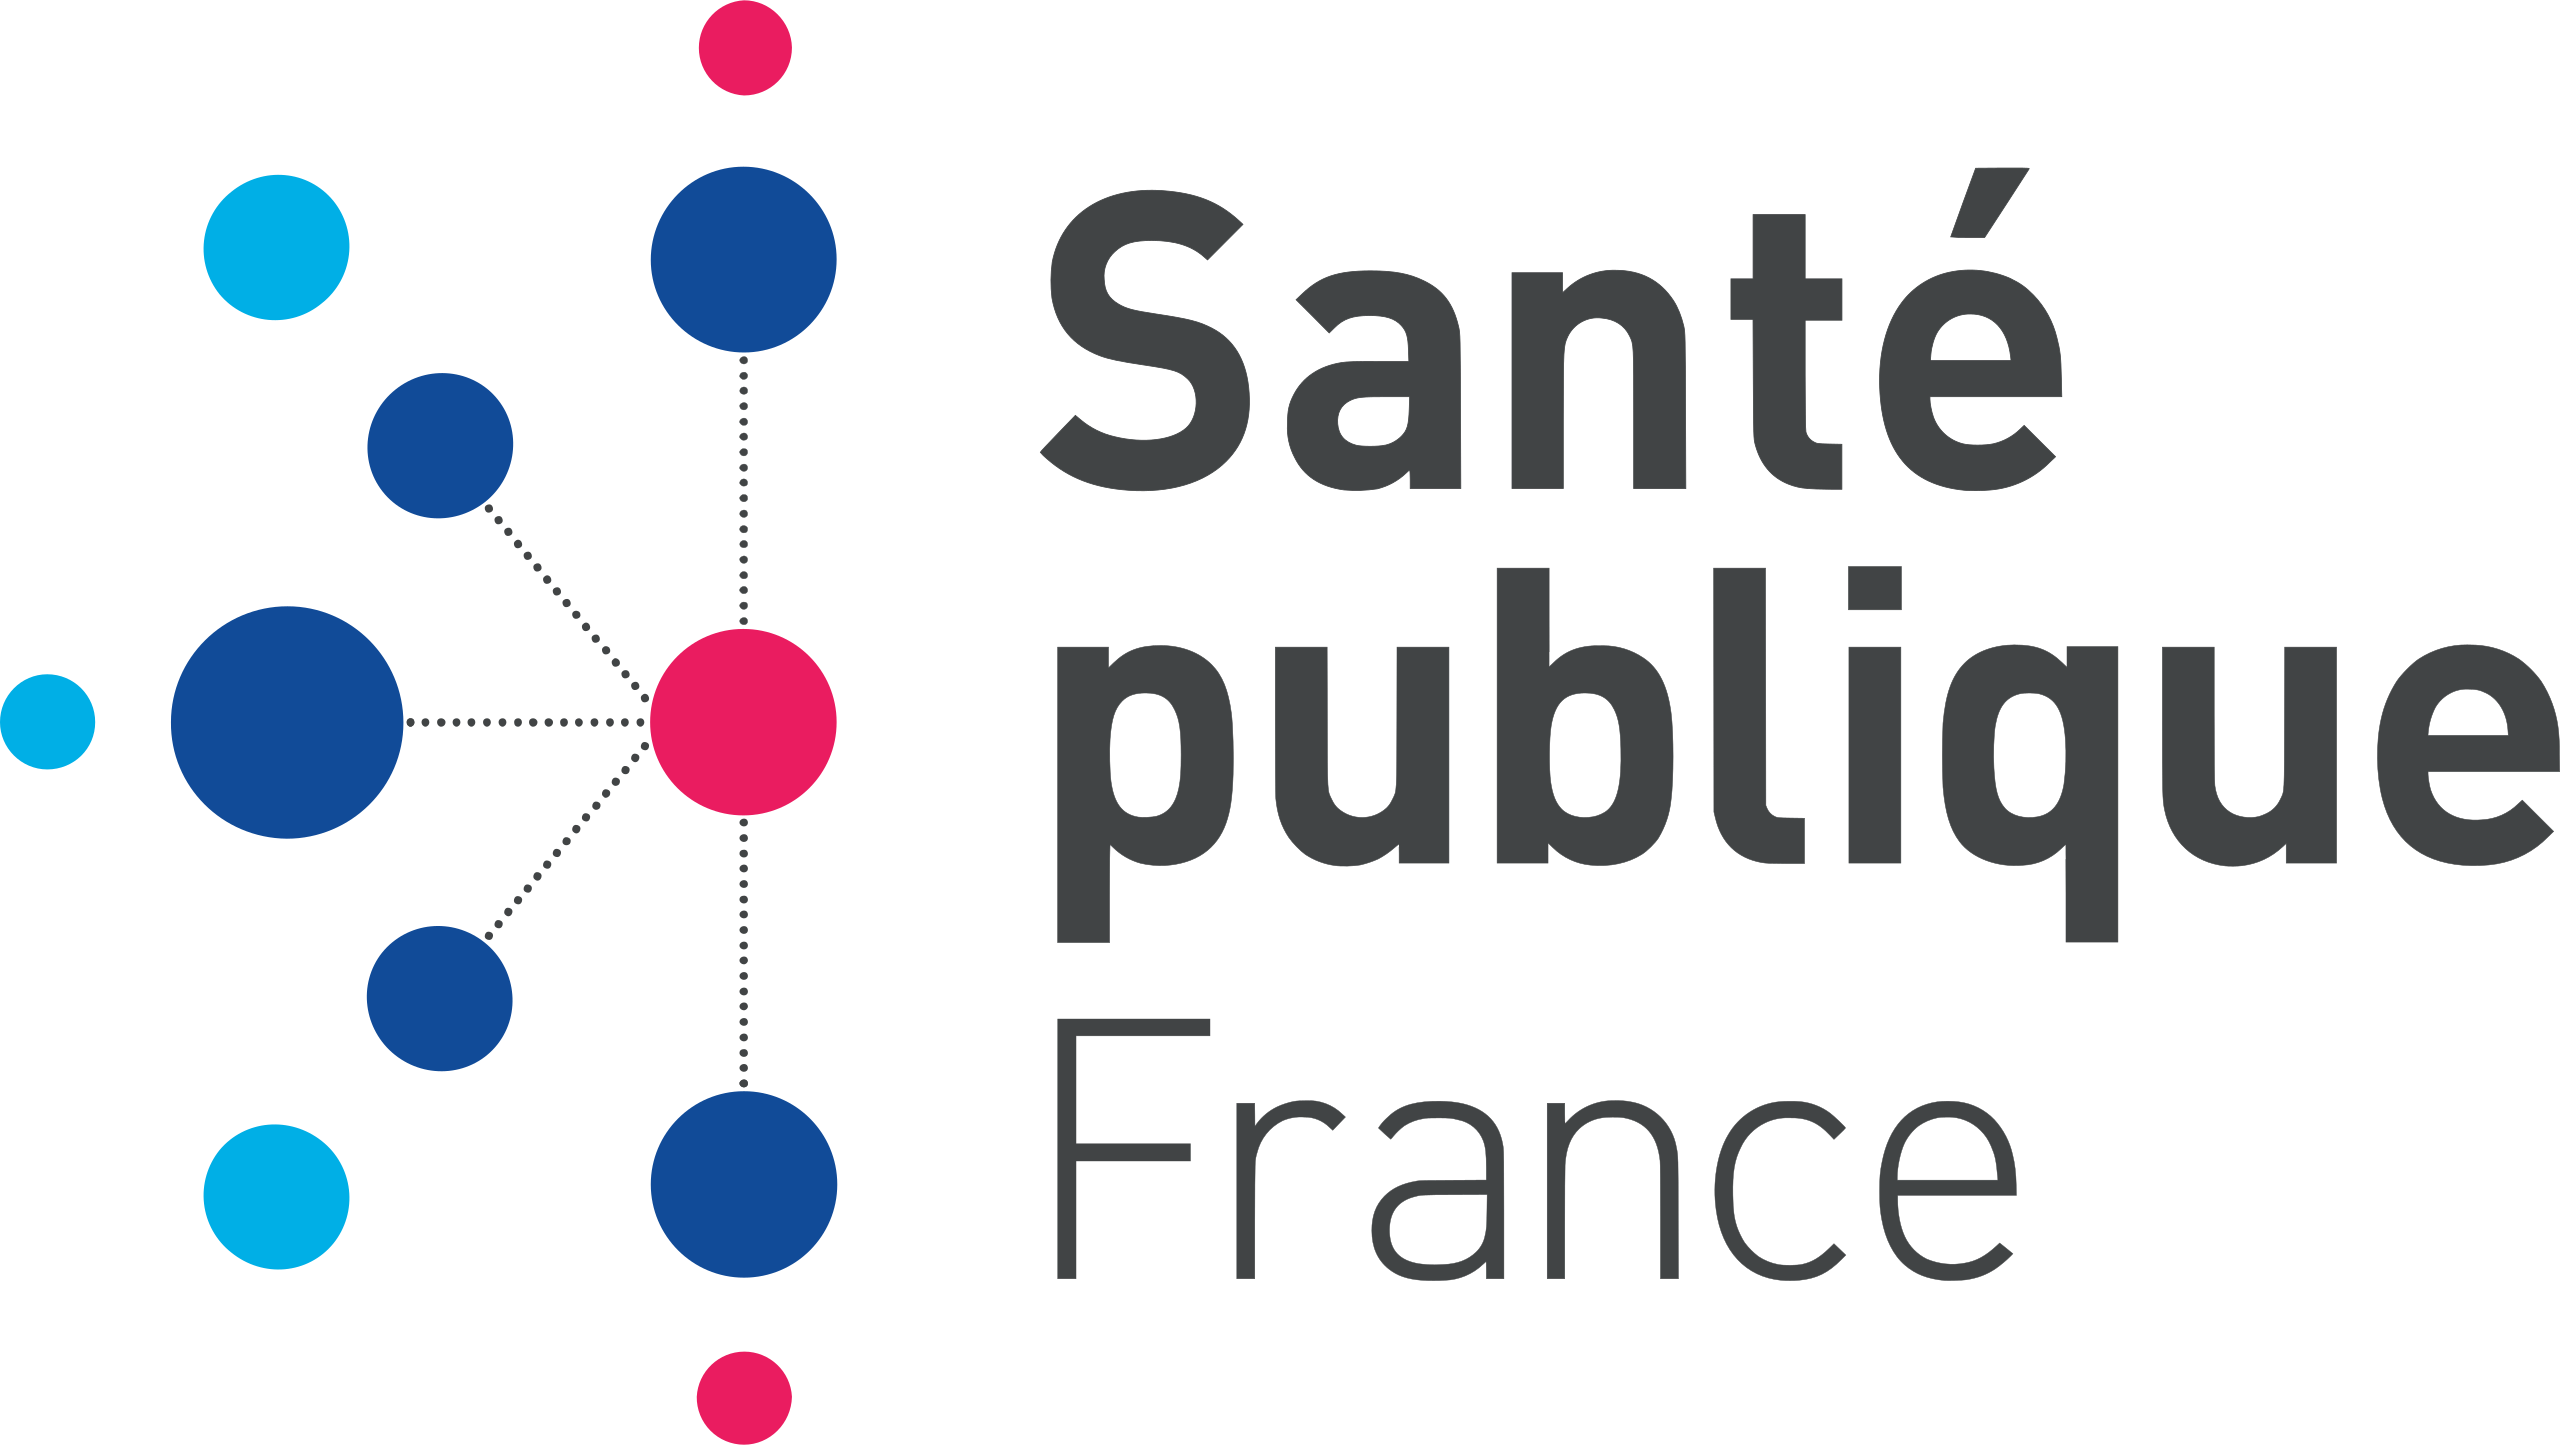



## 1. Introduction

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts qui permet de connaître la qualité nutritionnelle de leur produits.  
Ils souhaitent développer un système de suggestion ou d'auto-complétion pour remplir la base de données plus efficacement.

Mon rôle est de déterminer la faisabilité de cette application en analysant ces données et en produisants des graphiques compréhensible à tous.

**Données d'entrée**:
- [Tous les produits](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip)
- [Description de toutes les colonnes](https://world.openfoodfacts.org/data/data-fields.txt)

**Données de sortie**: 
- Rapport d'exploration
- Conclusion sur la faisabilité de l'application.

<!---
Critères d'évaluation:
- Vous avez défini les objectifs de son nettoyage de données en fonction de la problématique métier
- Vous avez défini sa démarche de préparation et nettoyage des données
-->

---

Je remarque que le fichier ne contient aucune données qui entrerait en conflit avec les 5 principes du RGPD (Règlement Général sur la Protection des Données):
- **Le principe de finalité** : le responsable d'un fichier ne peut enregistrer et utiliser des informations sur des personnes physiques que dans un but bien précis, légal et légitime ;
- **Le principe de proportionnalité et de pertinence** : les informations enregistrées doivent être pertinentes et strictement nécessaires au regard de la finalité du fichier ;
- **Le principe d'une durée de conservation limitée** : il n'est pas possible de conserver des informations sur des personnes physiques dans un fichier pour une durée indéfinie. Une durée de conservation précise doit être fixée, en fonction du type d'information enregistrée et de la finalité du fichier ;
- **Le principe de sécurité et de confidentialité** : le responsable du fichier doit garantir la sécurité des informations qu'il détient. Il doit en particulier veiller à ce que seules les personnes autorisées aient accès à ces informations ;
- **Les droits des personnes**.

## Importation des données

Afin de lire, nettoyer, analyser et visualiser les données, j'utilise les librairies suivantes:
- Pandas, 
- NumPy,
- Seaborn,
- Scikit-learn,
- Matplotlib.

In [2]:
import os.path 
import pandas as pd
import numpy as np
import math  

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer  
from sklearn.model_selection import GridSearchCV  
  
import seaborn as sns
import matplotlib.pyplot as plt

# Allow pandas to display all columns when displaying a table
pd.set_option("display.max_columns", None)

product_csv_path = '../input/fr.openfoodfacts.org.products.csv'
products = pd.read_csv(product_csv_path, sep='\t', low_memory=False)
products.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ]

In [6]:
test_data_not_null = products[products["energy_100g"].notna() & products["fat_100g"].notna() & products["nutrition-score-fr_100g"].notna()] 
len(test_data_not_null)

203733

In [9]:
from sklearn import linear_model


X = test_data_not_null[['energy_100g', 'fat_100g']]
y = test_data_not_null['nutrition-score-fr_100g']

regr = linear_model.LinearRegression()
regr.fit(X, y)

correlation_matrix = pd.concat([X, y], axis=1).corr()  
print(correlation_matrix)  

                         energy_100g  fat_100g  nutrition-score-fr_100g
energy_100g                 1.000000  0.082382                 0.064689
fat_100g                    0.082382  1.000000                 0.567727
nutrition-score-fr_100g     0.064689  0.567727                 1.000000


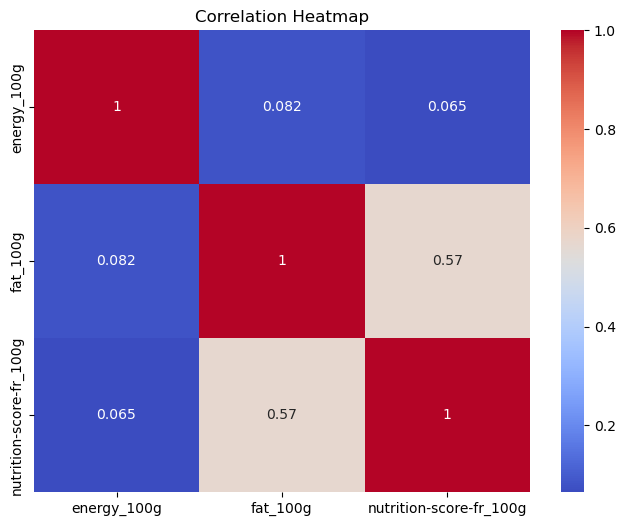

In [10]:
import seaborn as sns  
import matplotlib.pyplot as plt  
  
plt.figure(figsize=(8, 6))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  
plt.title('Correlation Heatmap')  
plt.show()  

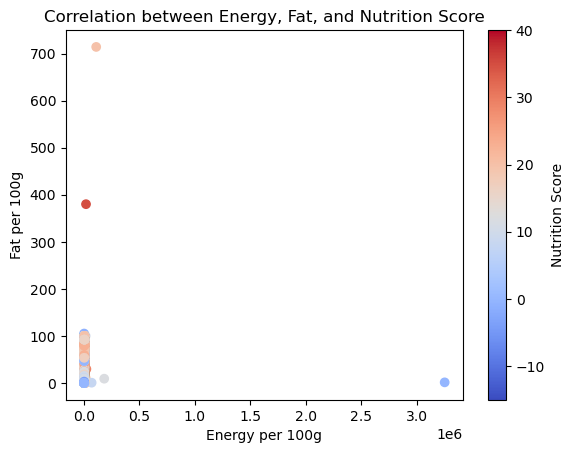

In [12]:
plt.scatter(X['energy_100g'], X['fat_100g'], c=y, cmap='coolwarm')  
plt.xlabel('Energy per 100g')  
plt.ylabel('Fat per 100g')  
plt.title('Correlation between Energy, Fat, and Nutrition Score')  
plt.colorbar(label='Nutrition Score')  
plt.show()